<a href="https://colab.research.google.com/github/Raven1914/Regresi-n/blob/master/Muspelheim_MX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

,Id_Cliente,D1,D2,D3,D4,D5,D6
1,1,0.0,0.0,0.0,0.0,0.0,1.0
2,2,0.0,0.0,0.0,0.0,0.0,1.0
3,3,0.0,1.0,0.0,0.0,0.0,0.0
4,4,0.0,1.0,1.0,0.0,0.0,1.0
5,5,0.0,1.0,0.0,0.0,0.0,0.0


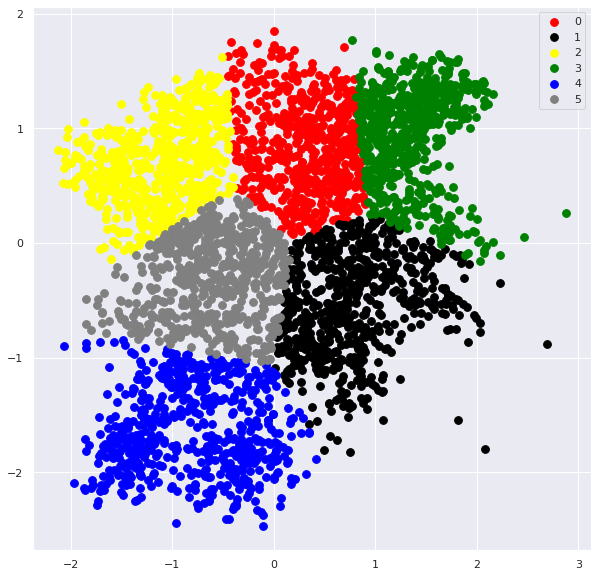

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
!pip install k-means-constrained 
from k_means_constrained import KMeansConstrained


df=pd.read_csv("https://raw.githubusercontent.com/JavierLilly/Proyecto_Eco/main/BDC_DATA.csv")

#Estandarizando las coordenadas
data= df[['lat','lon']].values.astype('float32',copy=False)
scaler = StandardScaler().fit(data)
data_scal = scaler.transform(data)
df_ = df
df_[['lat','lon']]=data_scal

#Construyendo el modelo de clustering min - max size
coor = df_[['lat','lon']]
model = KMeansConstrained(n_clusters=6,size_min=600,size_max=700,random_state=5565280).fit(coor)
y = model.predict(coor) # Predicion
df_['cluster'] = y
 
#Gráfica Todos con Frecuencia >=1 
cdict={0:'red',1:'black',2:'yellow',3:'green',4:'blue',5:'grey'}
plt.figure(figsize=(10,10))
sns.set()
for g in np.unique(y):
  plt.scatter(coor['lat'][y==g], coor['lon'][y==g], c = cdict[g], label = g, s = 60)
# plt.scatter(df['lat'][df['Frecuencia']==2],df['lon'][df['Frecuencia']==2],c='purple',s=80,alpha = .5)
# plt.scatter(df['lat'][df['Frecuencia']==3],df['lon'][df['Frecuencia']==3],c='brown',s=150,)

plt.legend()

#Reducimos los datos

reduced_data=df_.rename(index=df_['Id_Cliente'])
reduced_data = reduced_data.drop('Id_Cliente',axis=1)
matrix = pd.DataFrame(np.zeros((reduced_data.shape[0],6)),columns=[0,1,2,3,4,5],index=reduced_data.index)
id = reduced_data.index
cluster = reduced_data['cluster']
for i,j in zip(id,cluster):
  matrix[j][i] = 1 

#Algoritmo para calisifcar los putos restantes de frecuencia >=2

#Ratio que se actualizará con cada iteración con hiperparámetro alpha
def vol_ratio(vol_cluster, vol_tot_bal, alpha=0):
    res = np.zeros((6,6))
    np.fill_diagonal(res,vol_cluster/vol_tot_bal*alpha)
    return np.tanh(res)


#Matriz de distancia con una función de métrica dada
def matrix_distance(df_reduced,centers,metric = distance_matrix):
  sorted_df = df_reduced.sort_values(['Vol_Entrega'],ascending=False)
  coor = sorted_df[['lat','lon']]
  res = pd.DataFrame(metric(coor,centers),index=sorted_df.index)
  for i,j in zip(df_reduced.index,df_reduced['cluster'].values):
    res.loc[i][j]=0
  return res


#Actualizar los volúmenes totales de cada cluster con cada iteración
def update_vol(vol_cluster,df_reduced,indexs,id_Cliente):
  for i in indexs:
    vol_cluster[i]+=df_reduced['Vol_Entrega'].loc[id_Cliente]
  return vol_cluster


#Función que correrá las iteraciones
def main(df_,alpha):
  vol_cluster = df_.groupby(['cluster'])['Vol_Entrega'].sum()
  vol_tot_bal = (df_['Frecuencia'].T @ df_['Vol_Entrega'])/6
  df_reduced = df_[(df_['Frecuencia']>=2)].drop(['id_Agencia'],axis=1)
  cluster = df_reduced['cluster']
  centers = model.cluster_centers_
  dic={}

  dis_matrix = matrix_distance(df_reduced,centers)
  for ind in dis_matrix.index: 
    ratio = vol_ratio(vol_cluster,vol_tot_bal,alpha)
    decision_vector = dis_matrix.loc[ind] @ratio
    indexs = decision_vector.argsort()[:3][1:3] if df_['Frecuencia'].loc[ind]==3 else decision_vector.argsort()[:2][1]
    dic[ind]=indexs
    vol_cluster = update_vol(vol_cluster,df_reduced,[indexs],ind)
  return dic
dic = main(reduced_data,[.84,.83,.85,.84,.83,.85]) # Lo guardamos como un diccionario

#Llenamos la matriz para el output deseado
for i in dic: 
  for j in [dic[i]]:
    matrix.loc[i][j]=1
#Formato necesario   
subida=matrix.rename(columns={0:'D1',1:'D2',2:'D3',3:'D4',4:'D5',5:'D6'})
subida.insert(0,'Id_Cliente',matrix.index)
subida.to_csv('Eval_Final.csv',index=False)
subida.head()